# Simulation Setup

In [43]:
import numpy as np
from Bspline import bsplineBasis
import matplotlib.pyplot as plt
case = 'nonoverlap'
#case = 'spline'
if case == 'nonoverlap':
    p = 1000 # Number of dimensions
    c = 1 # Target meanshift is c * M
    k = 50 # Number of failuer Modes
    seed_list_OC = 20 # Seed of data generation
    sel_failure_mode = [3,11,22]    #  Failure Mode
    M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
else:
    p = 900
    c = 1 
    k0 = 6 # Can be changed (Knots)
    k = k0**2 # Failre mode number 
    degree = 4 # Overlap region? (Size of B-spline basis) 
    B1 = bsplineBasis(30,k0-degree+1,degree)
    M = np.kron(B1,B1)
    sel_failure_mode = [3,11,22]    #  Failure Mode
Ks = 5  #Select Top Ks control chart
nsensors = 5 # Number of selected sensors
ARL0 = 200 # Target ARL-IC
Tmax = 500 # Maximum length

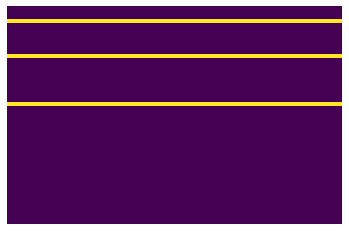

In [79]:
# plt.plot(B1)
plt.imshow(M[:,sel_failure_mode].sum(1).reshape([50,20]),aspect='auto')
plt.axis('off')
plt.savefig('true_anomaly.eps')

## Data generation Function
Data are generated as i.i.d normal before change. 
After change, add certain failure mode on the data.

In [49]:
def data_gen_func0(n_batch, Tmax, seed):
    # Generate normal samples
    np.random.seed(seed)    
    data = np.random.randn(n_batch,Tmax,p)
    return data

def data_gen_func1(n_batch, Tmax, seed, T0, delta):
    # Generate abnormal samples
    np.random.seed(seed)
    D1 = np.random.randn(n_batch, Tmax, p)
    shift = np.sum(M[:,sel_failure_mode]*delta,1)
    for i in range(T0,Tmax):
        for j in range(n_batch):
            D1[j,i,:] = D1[j,i,:]+shift
    return D1




## Failure Mode Visualization

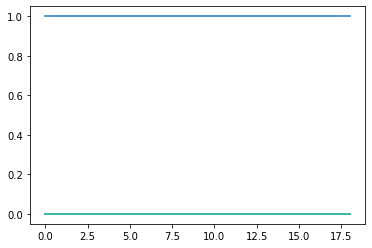

In [50]:
import matplotlib.pyplot as plt
#_ = plt.plot(M)
plt.plot(M[:19])

In [51]:
from ExtendedTSSRP import ExtendedTSSRP
from TSSRP import TSSRP
from Oracle import Oracle
from spc import spc
truesensidx = np.arange(nsensors)
nmodels = 8
model_all = [[] for i in range(nmodels)]

# p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode = 'T2'
    
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')
model_all[1] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'cusum')
model_all[2] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T1')
model_all[3] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2',sample_mode = 'mean')
model_all[4] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'cusum',sample_mode = 'mean')
model_all[5] = TSSRP(p, c, k,M,nsensors,Ks,L=-1,chart='srp',mode='T2')
model_all[6] = TSSRP(p, c, k,M,nsensors,Ks,L=-1,chart='cusum',mode='T2')
model_all[7] = Oracle(truesensidx, p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')

model_name = ['E_srp_T2','E_cusum','E_srp_T1','E_srp_T2_mean','E_cusum_mean','srp_T2','cumsum','oracle']
#experiment_log['model_name'] = model_name

# Result Visualization

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
T0 = 100
Tmax = 200
delta = 1
seed_list_OC = [0,2,5]
x = data_gen_func1(3, Tmax, seed_list_OC, T0, delta)

imodel = 0
model = model_all[imodel]

sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model.compute_monitoring_statistics(x[0],T0,-1)

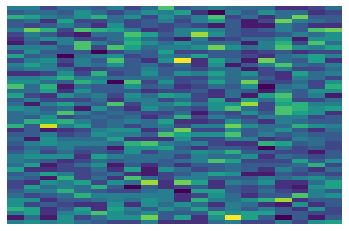

In [83]:
from collections import Counter
count_distr = Counter(sensor_selection_history[:T0].reshape(-1) ).items()

distr = np.zeros(1000)
for i,v in count_distr:
    distr[int(i)] = v
plt.imshow(distr.reshape(50,20),aspect='auto')
plt.axis('off')
plt.savefig('IC_long.eps')

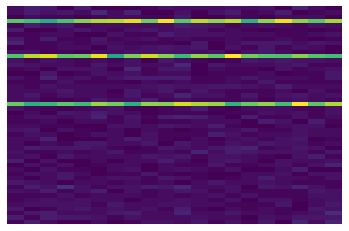

In [84]:
from collections import Counter
count_distr = Counter(sensor_selection_history[T0:].reshape(-1) ).items()

distr = np.zeros(1000)
for i,v in count_distr:
    distr[int(i)] = v
plt.imshow(distr.reshape(50,20),aspect='auto')
plt.axis('off')
plt.savefig('OC_long.eps')

## Control Chart
The control chart starts to increase around time 100, which is the time of change.

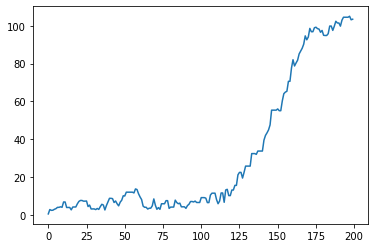

In [21]:
import matplotlib.pyplot as plt
plt.plot(sequential_statistics_topRsum)

## Failure Mode SRP statistics
The statistics of three failure modes are very clear to accumulate

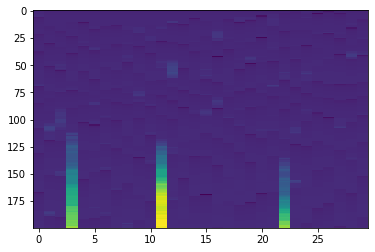

In [22]:
plt.imshow(sequential_statistics,aspect='auto')

## Look into each SRP statistics for different failure mode


In [130]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


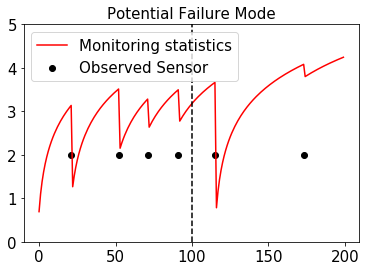

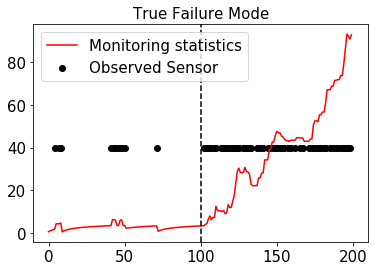

In [141]:
for plotfailuremode in [5,22]:
    arr = np.array([plotfailuremode in i for i in sensor_selection_history])
    plt.figure()    
    plt.plot(sequential_statistics[:,plotfailuremode],'r',label='Monitoring statistics')
    mode = (sensor_selection_history/(p/k)).astype(int)
    numSensorInFailureMode = np.zeros(Tmax)
    for ii,i in enumerate(mode):
        numSensorInFailureMode[ii] = np.sum([j ==plotfailuremode for j in i])
    idx = np.where(numSensorInFailureMode)[0]
    if plotfailuremode == 5:
        plt.title('Potential Failure Mode')
        plt.ylim((0,5))
        _ = plt.scatter(idx,numSensorInFailureMode[idx]*0+2,label = 'Observed Sensor',c='black')
    elif plotfailuremode == 22:
        plt.title('True Failure Mode')
        _ = plt.scatter(idx,numSensorInFailureMode[idx]*0+40,label = 'Observed Sensor',c='black')        
    plt.axvline(x=100,color='k',linestyle='--')

    plt.legend()
    plt.savefig(str(plotfailuremode)+'.eps')

In [ ]:
plt.plot(sequential_statistics[:130,0])
plt.plot(sequential_statistics[:130,22])

## Number of observed sensors in the failure mode
The number of observed sensor in different failure mode increases when we passes 100. 

In [ ]:
ii = 0
mode = (sensor_selection_history/(p/k)).astype(int)
numSensorInFailureMode = np.zeros(Tmax)
for ii,i in enumerate(mode):
    numSensorInFailureMode[ii] = np.sum([j in sel_failure_mode for j in i])
plt.plot(numSensorInFailureMode)

In [ ]:
import numpy as np
sens = np.array(x*0)

sens_sel = sensor_selection_history[t].astype(int)
sens_sel
sens = x*0
sens[isample][t][sens_sel]

In [ ]:
isample = 0
ims = []
import matplotlib.animation as animation
fig = plt.figure()

for t in range(200):
    sens_sel = sensor_selection_history[t].astype(int)
    sens = x*0
    sens[isample][t][sens_sel] = 1
    im = plt.imshow(sens[isample][t].reshape([30,30]))
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()

ani.save('dynamic_images.mp4')


## Failure Mode

In [ ]:
sensor_selection_history/50

## Top-R Failure Mode visualization



In [ ]:
plt.imshow(failure_mode_history,aspect='auto')
plt.colorbar()

In [ ]:
_ = plt.plot(failure_mode_history[:,:3])

## ARL results
ARL shows four methods:
- Extended TSSRP baed on sampled version of statistics (E_srp_sample)
- Extended TSSRP baed on mean version of statistics (E_srp_mean)
- Naive implementation of Extended TS CUSUM (E_cusum)
- TSSRP method (srp_T2)

Results show that E_cusum would not work since it doesn't encourage exploration at all. 
TSSRP does not use failure mode information and the result is much worse. 
sampled version of ETSSRP has the advantage over non-sampled version especially when meanshift is small

In [ ]:
import numpy as np
import pickle
# delta_all =  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.2,1.5,1.8,2,3,4]
delta_all =  [0.4,0.8,1,1.5,2,3,4]
model_name = ['E_srp_sample','E_srp_mean','E_cusum','srp_T2']
experiment_log = pickle.load( open( "2020Mar28_1020_exp.pickle", "rb" ) )
ARL_all_new = experiment_log['ARL1']

#ARL_5 = pickle.load( open( "ARL_5.pickle", "rb" ) )
#ARL_67 = pickle.load( open( "ARL_67.pickle", "rb" ) )
#ARL_all_new = np.concatenate((ARL_all,ARL_5[[5],:]),0)
#ARL_all_new = np.concatenate((ARL_all_new,ARL_67[[6,7],:]),0)
nmodels = 4
import matplotlib.pyplot as plt
%matplotlib inline
for i in [0,1,2,3]:
    plt.plot(delta_all,ARL_all_new[i,:],'x-',label=model_name[i])
    plt.xlabel('Chagne Magnitude delta')
    plt.ylabel('ARL_1')
    plt.legend()